In [1]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import torchvision

In [2]:
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

Number of samples in the training set: 60000
Number of samples in the test set: 10000
<PIL.Image.Image image mode=L size=28x28 at 0x19E8766D4E0> -> tensor(5)


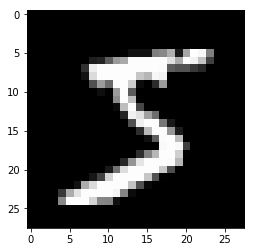

In [3]:
"""
Observing some of the data
"""
print("Number of samples in the training set:", len(training_data_set))
print("Number of samples in the test set:", len(test_data_set))
image, target = training_data_set[0]
print(image, "->", target)
plt.imshow(image)

In [4]:
"""
How to transform the data into vectors
"""
pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.2, 0.2, 0.2])
])
xs = pipeline(image)
xs.shape

torch.Size([1, 28, 28])

In [5]:
"""
Working with data loader for images
"""

# You need to transform the data to vectors to put it inside a data loader
training_data_set.transform = pipeline
test_data_set.transform = pipeline

data_loader = DataLoader(training_data_set, batch_size=2, shuffle=True)
for images, targets in data_loader:
    print(images)
    print(targets)
    break

tensor([[[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]],


        [[[-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          ...,
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000],
          [-2.5000, -2.5000, -2.5000,  ..., -2.5000, -2.5000, -2.5000]]]])
tensor([6, 1])


Training loss: 266.30801782011986
Accuracy: 54216/60000 (90.36%)
Training loss: 196.9488119855523
Accuracy: 54821/60000 (91.37%)
Training loss: 190.49393199384212
Accuracy: 54288/60000 (90.48%)
Training loss: 189.88029190897942
Accuracy: 54806/60000 (91.34%)
Training loss: 184.5315878763795
Accuracy: 55227/60000 (92.05%)
Training loss: 183.05543015897274
Accuracy: 55171/60000 (91.95%)
Training loss: 182.39777056127787
Accuracy: 55269/60000 (92.11%)
Training loss: 178.9000922665
Accuracy: 54606/60000 (91.01%)
Training loss: 176.48361643403769
Accuracy: 55212/60000 (92.02%)
Training loss: 175.32786958664656
Accuracy: 55361/60000 (92.27%)


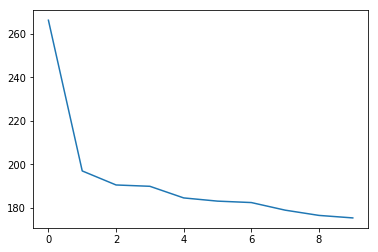

In [7]:
"""
Training a basic Linear classifier for images
"""

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28 * 28, 10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

def train(model):
    training_data_set.transform = pipeline
    test_data_set.transform = pipeline   

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linear_model.parameters(), lr=1e-3)

    training_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)
    test_data_loader = DataLoader(training_data_set, batch_size=100, shuffle=True)

    losses = []

    for epoch in range(10):
        cumulative_loss = 0.
        linear_model.train()
        for images, targets in training_data_loader:
            optimizer.zero_grad()
            got = linear_model(images, with_softmax=False)
            loss = criterion(got, targets)
            cumulative_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("Training loss: {0}".format(cumulative_loss))
        losses.append(cumulative_loss)

        correct = 0
        total = 0
        linear_model.eval()
        for images, targets in test_data_loader:
            got = linear_model(images, with_softmax=True)
            predicted = torch.argmax(got, dim=-1)
            predicted = predicted.view(-1)
            targets = targets.view(-1)
            correct += (predicted == targets).sum().item()
            total += len(targets)

        print("Accuracy: {0}/{1} ({2:.2f}%)".format(correct, total, 100 * correct/total))

    plt.plot(losses)
    plt.show()
    
linear_model = LinearClassifier()
train(linear_model)

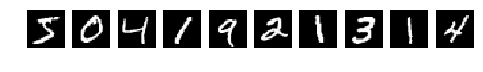

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [8]:
"""
Trying the model
"""

def predict(model, image_indexes):
    fig, ax = plt.subplots(figsize=(8, 8), ncols=len(image_indexes))
    predicted = []
    training_data_set.transform = None
    for image_idx in image_indexes:
        image, target = training_data_set[image_idx]
        xs = pipeline(image)
        xs = xs.unsqueeze(dim=0)
        ys = model(xs, with_softmax=True)
        predicted.append(torch.argmax(ys, dim=-1).item())
        ax[image_idx].imshow(image)
        ax[image_idx].set_axis_off()
    plt.show()
    print(predicted)

predict(linear_model, range(10))

Training loss: 275.2165778875351
Accuracy: 54693/60000 (91.16%)
Training loss: 167.9274307191372
Accuracy: 55421/60000 (92.37%)
Training loss: 144.613131031394
Accuracy: 55877/60000 (93.13%)
Training loss: 128.03434294089675
Accuracy: 56449/60000 (94.08%)
Training loss: 116.0249517261982
Accuracy: 56588/60000 (94.31%)
Training loss: 107.89741862565279
Accuracy: 57267/60000 (95.44%)
Training loss: 101.84295732527971
Accuracy: 57057/60000 (95.09%)
Training loss: 98.49630091525614
Accuracy: 57337/60000 (95.56%)
Training loss: 91.40333531796932
Accuracy: 57324/60000 (95.54%)
Training loss: 88.94622450694442
Accuracy: 57624/60000 (96.04%)


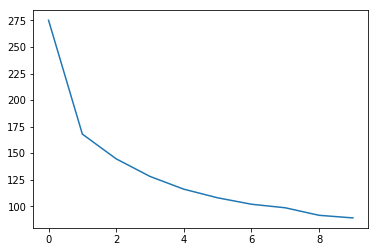

In [9]:
class TwoLayerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(28 * 28, 50), nn.ReLU(), nn.Linear(50, 10))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, xs, with_softmax=True):
        batch_size, channels, width, height = xs.shape
        xs = xs.reshape((batch_size, -1))
        xs = self.fc(xs)
        if with_softmax:
            xs = self.softmax(xs)
        return xs

two_layer_model = TwoLayerClassifier()
train(two_layer_model)

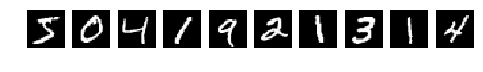

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [10]:
predict(two_layer_model, range(10))